<a href="https://colab.research.google.com/github/tinghe14/COURSE-2Deep-Learning/blob/main/Adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attacks

In Part 1, you will implement a simple adversarial attack on MNIST images. In the second part, you implement the same adversarial attack on CIFAR-10 images. In the third and final part, you will take a picture of an item you would expect to find in CIFAR-10 and use your trained model to generate an adversarial example.

**Imports:**

In [ ]:
## Standard Library
import time
import struct

## External Library
import numpy as np
import matplotlib.pyplot as plt

## Pytorch Imports
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable

In [ ]:
gpu_boole = torch.cuda.is_available()
print(gpu_boole)

True


### Part 1: MNIST Attack

**Defining the model and optimizer**

In [ ]:
## Defining the model:
class Net(nn.Module):
    def __init__(self, input_size, width, num_classes):
        super(Net, self).__init__()

        ##feedfoward layers:
        self.ff1 = nn.Linear(input_size, width) #input

        self.ff2 = nn.Linear(width, width) #hidden layers
        self.ff3 = nn.Linear(width, width)

        self.ff_out = nn.Linear(width, num_classes) #logit layer     

        ##activations:
        self.relu = nn.ReLU()
                
    def forward(self, input_data):
        out = self.relu(self.ff1(input_data)) 
        out = self.relu(self.ff2(out)) 
        out = self.relu(self.ff3(out))
        out = self.ff_out(out)
        return out #returns class probabilities for each image

net = Net(input_size = 784, width = 500, num_classes = 10)
if gpu_boole:
    net = net.cuda()

optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()


**Data pipeline:**

In [ ]:
#Downloading and unzipping MNIST data files:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*-ubyte.gz -f

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  40.2M      0 --:--:-- --:--:-- --:--:-- 40.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   626k      0 --:--:-- --:--:-- --:--:--  626k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  7286k      0 --:--:-- --:--:-- --:--:-- 7286k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  85698      0 --:--:-- --:--:-- --:--:-- 87346


In [ ]:
##Loading files into numpy arrays:
def read_idx(filename, boole=0):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        if boole:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10     
        else:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

xtrain = read_idx('train-images-idx3-ubyte', 1)
xtest = read_idx('t10k-images-idx3-ubyte', 1)
ytrain = read_idx('train-labels-idx1-ubyte')
ytest = read_idx('t10k-labels-idx1-ubyte')


xtrain = torch.Tensor(xtrain)
xtrain /= xtrain.max()
ytrain = torch.Tensor(ytrain).long()
xtest = torch.Tensor(xtest)
xtest /= xtest.max()
ytest = torch.Tensor(ytest).long()

## data_loaders:
train = torch.utils.data.TensorDataset(xtrain, ytrain)
test = torch.utils.data.TensorDataset(xtest, ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


In [ ]:
# test the shape
for images, labels in train_loader:
  print("train images.shape:", images.shape)
  print("train labels.shape:", labels.shape)
  break
for images, labels in test_loader:
  print("test images.shape:", images.shape)
  print("test labels.shape:", labels.shape)
  break

train images.shape: torch.Size([128, 28, 28])
train labels.shape: torch.Size([128])
test images.shape: torch.Size([128, 28, 28])
test labels.shape: torch.Size([128])


**Implement your adversarial attack here:**

In [ ]:
# FGSM tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
class GradientAttack():
  """
  
  """
  
  def __init__(self, loss, epsilon):
      """
      
      """
      self.loss = loss
      self.epsilon = epsilon

  def forward(self, x, y_true, model):
      """
      
      """
      # TODO: Implement a one step gradient attack
      # Step 1: Calculate the Loss and then calculate the
      # gradient of the Loss w.r.t the image
      pred = model(x)
      los = self.loss(pred, y_true)
      los.backward()

      # Step 2: Add the gradient (or its sign for each pixel),
      # multiplied by a small step size, to 
      # the original image
      # you might need to clamp the modified image to 
      # make sure the values of each pixel are between [0,1]
      sign = x.grad.data.sign()
      attack_output = x + sign * self.epsilon
      output = torch.clamp(attack_output, 0, 1)
      return output

                          

In [ ]:
## Initialize The Attack
adv_attack = GradientAttack(loss_metric, 0.1)

In [ ]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        #print("before view / size of train image:", images.size()) # (128, 28, 28)
        images = images.view(-1, 28*28) 
        #print("size of train image:", images.size()) # (128, 784)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        #print("size of predicted:", predicted.size()) # (128)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()
        
    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total




**Training Loop:** Your adverarial accuracy will also be printed in the loop.

Starting Training
Epoch 1 :
Train accuracy: 50.741669 %
Train loss: 0.017315
Test accuracy: 51.680000 %
Test loss: 0.017482
Test accuracy adversarial: 16.080000 %
Test loss adversarial: 0.018122
Elapsed time for epoch: 1.8383369445800781 s
ETA of completion: 0.27575054168701174 minutes



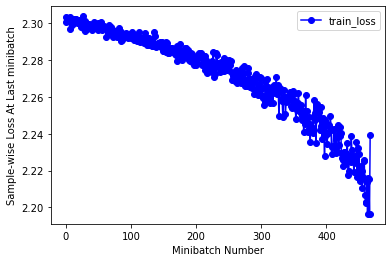

Epoch 2 :
Train accuracy: 69.813332 %
Train loss: 0.010296
Test accuracy: 70.250000 %
Test loss: 0.010260
Test accuracy adversarial: 38.790001 %
Test loss adversarial: 0.014662
Elapsed time for epoch: 1.8214702606201172 s
ETA of completion: 0.24286270141601562 minutes



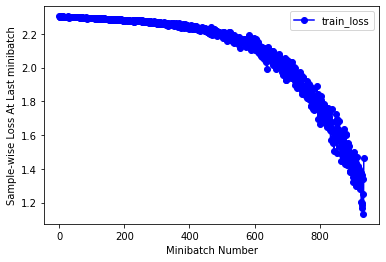

Epoch 3 :
Train accuracy: 81.900002 %
Train loss: 0.004962
Test accuracy: 82.299995 %
Test loss: 0.004883
Test accuracy adversarial: 30.539999 %
Test loss adversarial: 0.014265
Elapsed time for epoch: 1.788686990737915 s
ETA of completion: 0.2086801489194234 minutes



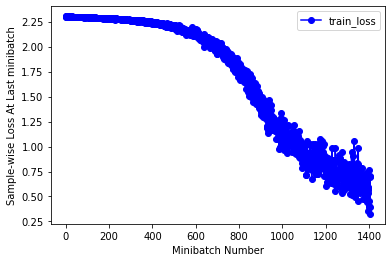

Epoch 4 :
Train accuracy: 86.294998 %
Train loss: 0.003692
Test accuracy: 86.500000 %
Test loss: 0.003610
Test accuracy adversarial: 30.689999 %
Test loss adversarial: 0.015310
Elapsed time for epoch: 1.8403680324554443 s
ETA of completion: 0.18403680324554444 minutes



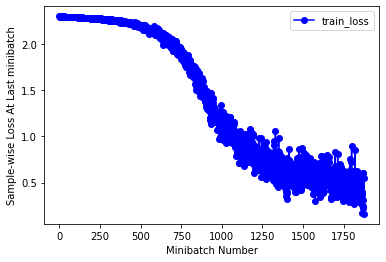

Epoch 5 :
Train accuracy: 88.168335 %
Train loss: 0.003159
Test accuracy: 88.329994 %
Test loss: 0.003084
Test accuracy adversarial: 30.099998 %
Test loss adversarial: 0.016363
Elapsed time for epoch: 1.8272244930267334 s
ETA of completion: 0.15226870775222778 minutes



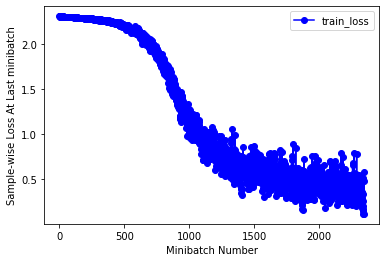

Epoch 6 :
Train accuracy: 89.298332 %
Train loss: 0.002872
Test accuracy: 89.329994 %
Test loss: 0.002809
Test accuracy adversarial: 29.170000 %
Test loss adversarial: 0.017288
Elapsed time for epoch: 1.7976970672607422 s
ETA of completion: 0.11984647115071614 minutes



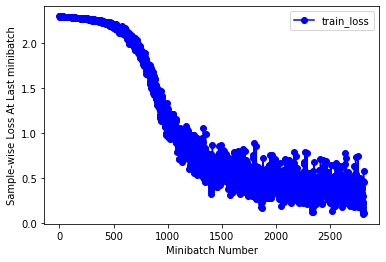

Epoch 7 :
Train accuracy: 90.043335 %
Train loss: 0.002677
Test accuracy: 90.150002 %
Test loss: 0.002624
Test accuracy adversarial: 27.939999 %
Test loss adversarial: 0.017982
Elapsed time for epoch: 1.8695757389068604 s
ETA of completion: 0.09347878694534302 minutes



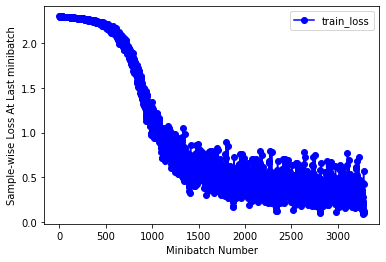

Epoch 8 :
Train accuracy: 90.648331 %
Train loss: 0.002521
Test accuracy: 90.750000 %
Test loss: 0.002476
Test accuracy adversarial: 27.279999 %
Test loss adversarial: 0.018490
Elapsed time for epoch: 1.8001060485839844 s
ETA of completion: 0.06000353495279948 minutes



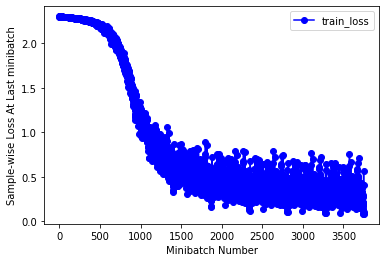

Epoch 9 :
Train accuracy: 91.248337 %
Train loss: 0.002386
Test accuracy: 91.129997 %
Test loss: 0.002348
Test accuracy adversarial: 26.849998 %
Test loss adversarial: 0.018870
Elapsed time for epoch: 1.8522493839263916 s
ETA of completion: 0.03087082306543986 minutes



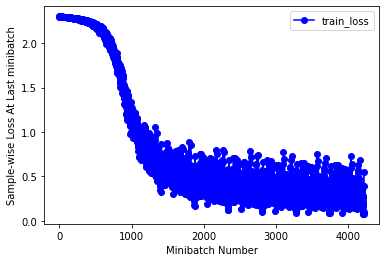

Epoch 10 :
Train accuracy: 91.678337 %
Train loss: 0.002263
Test accuracy: 91.599998 %
Test loss: 0.002233
Test accuracy adversarial: 26.389999 %
Test loss adversarial: 0.019173
Elapsed time for epoch: 1.8639051914215088 s
ETA of completion: 0.0 minutes



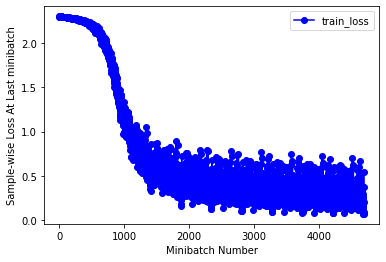

In [ ]:
#number of epochs to train for:
epochs = 10

#define batch train loss recording array for later visualization/plotting:
loss_batch_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
  time1 = time.time() #timekeeping

  for i, (x,y) in enumerate(train_loader):
    
    if gpu_boole:
      x = x.cuda()
      y = y.cuda()

    x = x.view(x.shape[0],-1)

    #loss calculation and gradient update:

    if i > 0 or epoch > 0:
      optimizer.zero_grad()
    outputs = net.forward(x)
    loss = loss_metric(outputs,y)
    loss.backward()   
    
    if i > 0 or epoch > 0:
      loss_batch_store.append(loss.cpu().data.numpy().item())

    ##perform update:
    optimizer.step()

  print("Epoch",epoch+1,':')
  train_perc, train_loss = train_eval()
  test_perc, test_loss = test_eval()
  test_eval_adv()

  time2 = time.time() #timekeeping
  print('Elapsed time for epoch:',time2 - time1,'s')
  print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
  print()

    ## Plot batch-wise train loss curve:
  plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
  plt.xlabel('Minibatch Number')
  plt.ylabel('Sample-wise Loss At Last minibatch')
  plt.legend()
  plt.show()

Visualize Some Examples

Visualize a original Image and its corresponding adversarial example.

Print the prediction of the model for both of the images.

The adversarial sample should look similar to the original image and be easily and correctly classified by a human.

tensor([3], device='cuda:0')


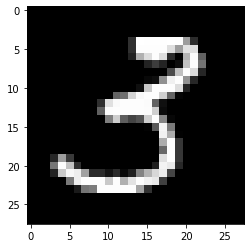

In [ ]:
plt.imshow(x[0].cpu().reshape(28,28),cmap='gray')
print(net(x[0].view(-1,784)).argmax(dim=1))

tensor(5, device='cuda:0')


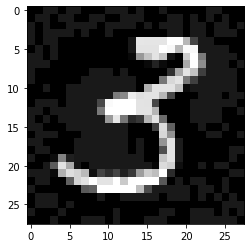

In [ ]:
labels = net(x[0].view(-1,784)).argmax(dim=1) # is 3
in_x = Variable(x[[0]], requires_grad=True) # 1, 784
adv_x = adv_attack.forward(in_x, labels, net) # 1, 784
plt.imshow(adv_x[0].detach().cpu().reshape(28,28),cmap='gray')
print(net(adv_x[0].view(-1,784)).argmax(dim=1)[0])

### Part 2: CIFAR Attack

Now, you will attempt to use the same type of adversarial attack against a CIFAR classifier. You should use code structured similarly to that from above. We provide some struture below to get you started. We recommend trying the resnet50 model to begin, but feel free to experiment with model architectures and hyperparameters.

In [ ]:
import torch
import torchvision
from torchvision.models import vgg16, resnet50
import torchvision.transforms as transforms

In [ ]:
## Transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     #transforms.Grayscale(num_output_channels=1),
     transforms.Resize(64)])

## Batch Size
batch_size = 128

## Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
## Helper
def initialize_model(use_resnet=True, pretrained=False, nclasses=10):
    """
    
    """
    ## Initialize Model
    if use_resnet:
        model = resnet50(pretrained=pretrained)
    else:
        model = vgg16(pretrained=True)
    ## Freeze Early Layers if Pretrained
    if pretrained:
        for parameter in model.parameters():
            parameter.requires_grad = False
    ## Update Output Layer
    if use_resnet:
        model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = nn.Linear(2048, nclasses)
        
    else:
        model.classifier._modules['6'] = nn.Linear(4096, nclasses)
    return model

## Get Model
net = initialize_model(True, False, 10)

### TODO: Train the model using the same structure as before

In [ ]:
# test the shape
for images, labels in trainloader:
  print("train images.shape:", images.shape)
  print("train labels.shape:", labels.shape)
  break
for images, labels in testloader:
  print("test images.shape:", images.shape)
  print("test labels.shape:", labels.shape)
  break

trainset.classes
# attack is the same # adv_attack 

train images.shape: torch.Size([128, 3, 64, 64])
train labels.shape: torch.Size([128])
test images.shape: torch.Size([128, 3, 64, 64])
test labels.shape: torch.Size([128])


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
if gpu_boole:
    net = net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()
## Initialize The Attack
adv_attack = GradientAttack(loss_metric, 0.1)
#print(net)

In [ ]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in trainloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        #print("before view / size of train image:", images.size()) # (128, 28, 28) # batch size: 128
        #images = images.view(-1, 28*28) 
        #print("size of train image:", images.size()) # (128, 784) # (128, 28, 28)
        outputs = net(images)
        #print("outputs:", outputs)
        _, predicted = torch.max(outputs.data, 1)
        #print("size of predicted:", predicted.size()) # (128)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()
        
    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        #images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        #images = images.view(-1, 28*28)
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total


Starting Training
Epoch 1 :
Train accuracy: 27.453999 %
Train loss: 0.017374
Test accuracy: 27.719999 %
Test loss: 0.017545
Test accuracy adversarial: 21.799999 %
Test loss adversarial: 0.019711
Elapsed time for epoch: 96.75131106376648 s
ETA of completion: 14.512696659564972 minutes



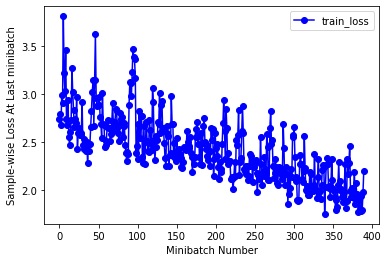

Epoch 2 :
Train accuracy: 37.666000 %
Train loss: 0.013450
Test accuracy: 37.399998 %
Test loss: 0.013696
Test accuracy adversarial: 26.740000 %
Test loss adversarial: 0.016928
Elapsed time for epoch: 95.75020384788513 s
ETA of completion: 12.766693846384685 minutes



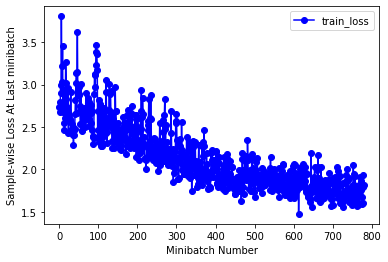

Epoch 3 :
Train accuracy: 41.118000 %
Train loss: 0.012826
Test accuracy: 38.719997 %
Test loss: 0.013426
Test accuracy adversarial: 25.119999 %
Test loss adversarial: 0.017850
Elapsed time for epoch: 96.03240299224854 s
ETA of completion: 11.203780349095663 minutes



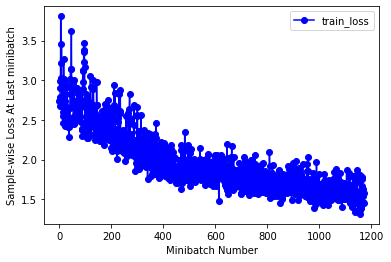

Epoch 4 :
Train accuracy: 47.253998 %
Train loss: 0.011257
Test accuracy: 44.169998 %
Test loss: 0.012039
Test accuracy adversarial: 26.459999 %
Test loss adversarial: 0.017073
Elapsed time for epoch: 95.67709803581238 s
ETA of completion: 9.567709803581238 minutes



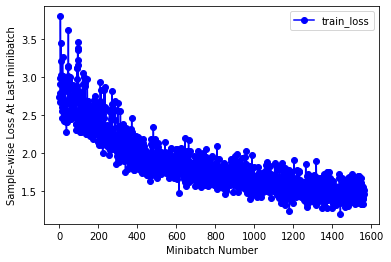

Epoch 5 :
Train accuracy: 53.253998 %
Train loss: 0.010125
Test accuracy: 48.759998 %
Test loss: 0.011212
Test accuracy adversarial: 28.379999 %
Test loss adversarial: 0.016785
Elapsed time for epoch: 95.86223411560059 s
ETA of completion: 7.988519509633382 minutes



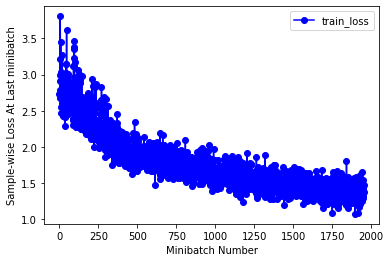

Epoch 6 :
Train accuracy: 54.851997 %
Train loss: 0.009967
Test accuracy: 49.129997 %
Test loss: 0.011457
Test accuracy adversarial: 28.539999 %
Test loss adversarial: 0.017787
Elapsed time for epoch: 96.03330445289612 s
ETA of completion: 6.402220296859741 minutes



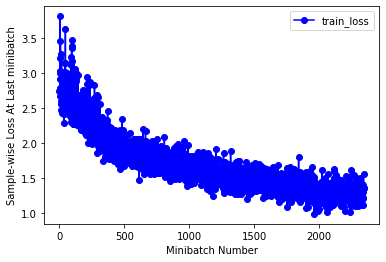

Epoch 7 :
Train accuracy: 58.689999 %
Train loss: 0.008985
Test accuracy: 50.570000 %
Test loss: 0.010908
Test accuracy adversarial: 27.549999 %
Test loss adversarial: 0.017999
Elapsed time for epoch: 96.03954768180847 s
ETA of completion: 4.801977384090423 minutes



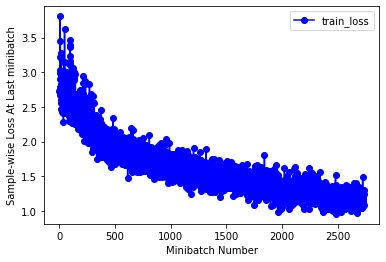

Epoch 8 :
Train accuracy: 63.717999 %
Train loss: 0.008000
Test accuracy: 53.509998 %
Test loss: 0.010682
Test accuracy adversarial: 28.980000 %
Test loss adversarial: 0.018294
Elapsed time for epoch: 95.83561778068542 s
ETA of completion: 3.194520592689514 minutes



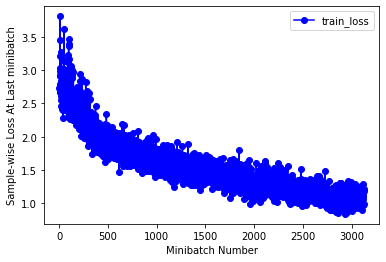

Epoch 9 :
Train accuracy: 65.278000 %
Train loss: 0.007422
Test accuracy: 52.689999 %
Test loss: 0.010809
Test accuracy adversarial: 27.269999 %
Test loss adversarial: 0.019594
Elapsed time for epoch: 95.70138430595398 s
ETA of completion: 1.5950230717658997 minutes



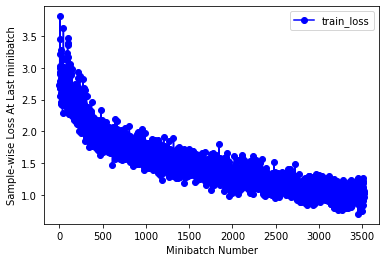

Epoch 10 :
Train accuracy: 72.771996 %
Train loss: 0.006159
Test accuracy: 55.969997 %
Test loss: 0.010191
Test accuracy adversarial: 29.439999 %
Test loss adversarial: 0.018957
Elapsed time for epoch: 95.89571189880371 s
ETA of completion: 0.0 minutes



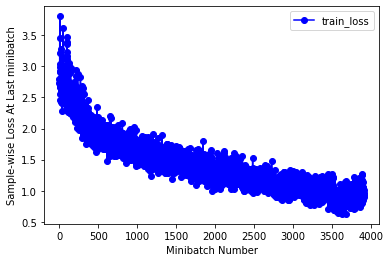

In [ ]:
#number of epochs to train for:
epochs = 10

#define batch train loss recording array for later visualization/plotting:
loss_batch_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
    #print("Epoch:", epoch+1, "out of", epochs)
    time1 = time.time() #timekeeping

    for i, (x,y) in enumerate(trainloader):

      if gpu_boole:
        x = x.cuda()
        y = y.cuda()
      #print("x.size():", x.size()) # 128, 3, 64, 64
      #print("y.size():", y.size()) # 128
      #x = x.sq ueeze() 

      #loss calculation and gradient update:

      if i > 0 or epoch > 0:
          optimizer.zero_grad()
      outputs = net.forward(x)
      loss = loss_metric(outputs,y)
      loss.backward()

      if i > 0 or epoch > 0:
          loss_batch_store.append(loss.cpu().data.numpy().item())

      ##perform update:
      optimizer.step()

    print("Epoch",epoch+1,':')
    train_perc, train_loss = train_eval()
    test_perc, test_loss = test_eval()
    test_eval_adv()

    time2 = time.time() #timekeeping
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
    print()

    ## Plot batch-wise train loss curve:
    plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
    plt.xlabel('Minibatch Number')
    plt.ylabel('Sample-wise Loss At Last minibatch')
    plt.legend()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of image: torch.Size([128, 3, 64, 64])
label: tensor(7, device='cuda:0')


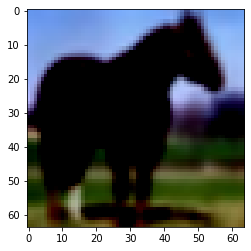

In [ ]:
testimg,testlabel = next(iter(trainloader))
print("shape of image:",testimg.size())
plt.imshow(torch.permute(testimg[0,...], (1,2,0)))
print("label:",net(testimg.cuda()).argmax(dim=1)[0]) #7: horse

attacked label: tensor(2, device='cuda:0')


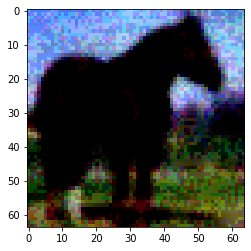

In [ ]:
labels = net(testimg.cuda()).argmax(dim=1) # 128
in_x = Variable(testimg.cuda(), requires_grad=True) # 128, 3, 64, 64
adv_x = adv_attack.forward(in_x, labels, net)
attack = adv_x #128,3,64,64
plt.imshow(torch.permute(attack[0,...].detach().cpu(), (1,2,0)))
print("attacked label:", net(attack).argmax(dim=1)[0]) #2: bird 

### Part 3: Real World Example

Use your phone or other camera device to take a picture of an item you would find in CIFAR-10. Upload the photo to this notebook and format it so that it can be analyzed by your image classifier and the adversarial example generator.

In [ ]:
## Complete your work below

In [ ]:
from PIL import Image

img = Image.open("mydog.jpg")
trans = transforms.ToTensor()
image = trans(img)
#image.size() #3, 1189, 1188

shape of image: torch.Size([1, 3, 1189, 1188])
label: tensor(2, device='cuda:0')


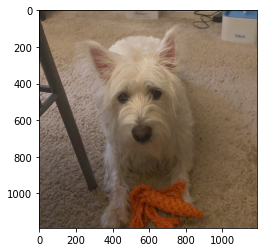

In [ ]:
image = image[None,:,:,:]
print("shape of image:",image.size())
plt.imshow(torch.permute(image[0,...], (1,2,0)))
print("label:",net(image.cuda()).argmax(dim=1)[0]) #2: bird

attacked label: tensor(2, device='cuda:0')


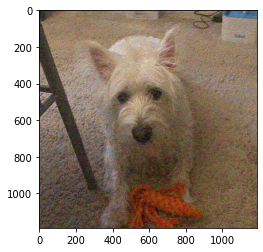

In [ ]:
labels = net(image.cuda()).argmax(dim=1) 
in_x = Variable(image.cuda(), requires_grad=True) 
adv_x = adv_attack.forward(in_x, labels, net)
attack = adv_x 
plt.imshow(torch.permute(attack[0,...].detach().cpu(), (1,2,0)))
print("attacked label:", net(attack).argmax(dim=1)[0]) #2: bird 